## Training an image classifier on a pre-trained model using PyTorch and Haar Cascade Classifier.
The following code has been adapted from various sources including: https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/blob/main/Week-3-CNNs-and-image-classification/train-image-classifier-from-pretrained.ipynbdebugged andareas have been debugged using GPT.
In this notebook I clean my image dataset, create new data points for each image and implement these changes back into my 'emtional-class-datasheet.csv'. 
Additionally, I implement ResNet and VisionTransformer for training.

In [2]:
!pip install pytesseract

In [3]:
import os
import pandas as pd
import cv2
import torch
import torchvision

import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pytesseract

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

In [4]:
# Double check my class datasets are recognised:
os.listdir('/notebooks/AI-for-Media-project-23-24/my-classification-dataset')

['disgusted-face',
 'neutral-face',
 'sad-face',
 'scared-face',
 'angry-face',
 'surprised-face',
 'happy-face',
 '.ipynb_checkpoints']

In [5]:
# I had an unexpected file in my class dataset ('.ipynb_checkpoints') and wanted to double chheck the conentss, if any.
directory_path = '/notebooks/AI-for-Media-project-23-24/my-classification-dataset'

# List the contents of the directory
contents = os.listdir(directory_path)

if '.ipynb_checkpoints' in contents:
    checkpoint_path = os.path.join(directory_path, '.ipynb_checkpoints')
    checkpoint_contents = os.listdir(checkpoint_path)
    print(checkpoint_contents)
else:
    print(".ipynb_checkpoints directory does not exist in the specified directory.")
    # This created an empty list, nothing to worry about!

[]


## Data pre-processing
### A. Remove any duplicates in 'my-classification-dataset' 
I had noticed a few duplicates when woorking with the same custom dataset for another data science module for k-means cluster experimentation. The private repository can be found here: https://git.arts.ac.uk/23002156/Intro-Data-Science-Portfolio-2024.
### B. Isolating faces from images ( particularly for magazine data and to remove solely text data thta may have been collected during sampling)
I could exclude images with text using a text detector, but this may reduce the dataset significantly.
Use Haar Cascade classifier ( which uses feature based object detection) available from: https://github.com/opencv/opencv/tree/4.x/data/haarcascades.
### C. Update 'emotional-class-datasheet.csv', considering any new changes


In [4]:
# Code adapted from: https://www.geeksforgeeks.org/reading-image-opencv-using-python/?ref=lbp 
# Remove Duplicates:

import hashlib

folder_path = '/notebooks/AI-for-Media-project-23-24/my-classification-dataset'

# Load CSV file
csv_file_path = 'emotional-class-datasheet.csv'
data = pd.read_csv(csv_file_path)

# Initialize a dictionary to store file hashes
file_hashes = {}

# Iterate through the subfolders
for subdir, dirs, files in os.walk(folder_path):
    # Iterate through the files in each subfolder
    for filename in files:
        file_path = os.path.join(subdir, filename)
        
        # Calculate the hash of the file content
        with open(file_path, 'rb') as file:
            file_hash = hashlib.md5(file.read()).hexdigest()
        
        # Check for duplicates based on file content
        if file_hash in file_hashes.values():
            # Remove duplicate file
            os.remove(file_path)
            # Remove corresponding row from CSV
            data = data[data['Image URL'] != file_path]
        else:
            file_hashes[filename] = file_hash

# Save the updated data to the CSV file
data.to_csv(csv_file_path, index=False)

In [6]:
!pip install dlib

  Using cached dlib-19.24.2.tar.gz (11.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dlib: filename=dlib-19.24.2-cp39-cp39-linux_x86_64.whl size=4078075 sha256=9002f1685a4b99a97bf5d4c61374367176547c9669084cc4633be164e57c1339
  Stored in directory: /root/.cache/pip/wheels/73/d6/00/06093a7791e5f6da7347a6e7d4141ae3a8c96d676043c1a271
Successfully built dlib


In [7]:
import dlib
import cv2
import pandas as pd
import os

# The following code has been adapted from Week 4,Sensing bodies : https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/commit/981594f418f30d02fcff4998cc93f39d4108b608 and debugged using GPT
# Isolate faces using Haar Casscade Classifier, I learnt how to implement this classifier from: https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Object_Detection_Face_Detection_Haar_Cascade_Classifiers.php
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml')

# Load in facial landmark predictor 
predictor_path = 'shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(predictor_path)

# Path to the directory containing your images
directory_path = '/notebooks/AI-for-Media-project-23-24/my-classification-dataset'

data = []

# Iterate over all files in the directory, as adapted from: https://www.slingacademy.com/article/python-how-to-iterate-over-all-files-in-a-directory/
for root, dirs, files in os.walk(directory_path):
    for filename in files:
        if filename.endswith('.jpg') or filename.endswith('.png'):
            # Load the image
            image_path = os.path.join(root, filename)
            print("Processing image", image_path)
            image = cv2.imread(image_path)
        

        # Convert the image to grayscale for feature extraction, which helps to reduce any noise when the images are processed and hopefully better training.
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                # Detect faces in the image
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        
        # If there aren't any faces present, print so.
        if len(faces) == 0:
                print("No faces detected in", image_path)
                # If no faces present then remove the file from my dataset entirely.
                data.append({'Image': filename, 'Path': image_path, 'NumFaces': len(faces)})
                continue
        
        # Extract emotion class from the directory path to add this to my DataFrame.
        emotion_class = os.path.basename(root)
            
            
         # Next I need to find eye, mouth and nose landmark points for each image. I started with creating variables to store the data.
         # Code debugged  using GPT and adapted from https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/tree/main/Week-4-Sensing-bodies and https://dontrepeatyourself.org/post/how-to-detect-face-landmarks-with-dlib-python-and-opencv/?utm_content=cmp-true
        for (x,y,w,h) in faces:
            face_rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))
            landmarks = predictor(gray, face_rect)

                    # Extract landmark coordinates
            eyes_x, eyes_y, nose_x, nose_y, mouth_x, mouth_y = [], [], [], [], [], []


                    # Extract landmark coordinates for eyes, nose, and mouth
                    # (Eyes)
            for n in range(36, 48):  
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                eyes_x.append(x)
                eyes_y.append(y)

                    # (Nose)
            for n in range(27, 35):  
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                nose_x.append(x)
                nose_y.append(y)

                    # (Mouth)
            for n in range(48, 68):  
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                mouth_x.append(x)
                mouth_y.append(y)

                    # Append extracted features to list
            
            # Append extracted features to list
            data.append({'Image': filename, 'EmotionClass': emotion_class, 'TotalFaceArea': w * h, 'EyesX': eyes_x, 'EyesY': eyes_y,
                         'NoseX': nose_x, 'NoseY': nose_y, 'MouthX': mouth_x, 'MouthY': mouth_y})

        
# Create a DataFrame to store the new data
df = pd.DataFrame(data)

# Write the data to a CSV file
df.to_csv('facial_landmarks_data.csv', index=False)

# To signify that all processes have been completed
print("Data processing complete.")

Processing image /notebooks/AI-for-Media-project-23-24/my-classification-dataset/disgusted-face/pinterest_1105774514745986841.jpg
Processing image /notebooks/AI-for-Media-project-23-24/my-classification-dataset/disgusted-face/pinterest_1105774514746051261.jpg
Processing image /notebooks/AI-for-Media-project-23-24/my-classification-dataset/disgusted-face/pinterest_1105774514745986834.jpg
No faces detected in /notebooks/AI-for-Media-project-23-24/my-classification-dataset/disgusted-face/pinterest_1105774514745986834.jpg
Processing image /notebooks/AI-for-Media-project-23-24/my-classification-dataset/disgusted-face/pinterest_1105774514745986867.jpg
Processing image /notebooks/AI-for-Media-project-23-24/my-classification-dataset/disgusted-face/pinterest_1105774514746051380.jpg
No faces detected in /notebooks/AI-for-Media-project-23-24/my-classification-dataset/disgusted-face/pinterest_1105774514746051380.jpg
Processing image /notebooks/AI-for-Media-project-23-24/my-classification-dataset/d

In [9]:
# What does my DataFrame look like? Have these changes been made?
df

,Image,EmotionClass,TotalFaceArea,EyesX,EyesY,NoseX,NoseY,MouthX,MouthY,Path,NumFaces
0,pinterest_1105774514745986841.jpg,disgusted-face,205209.0,"[430, 456, 481, 500, 477, 451, 601, 623, 645, ...","[306, 298, 300, 318, 321, 318, 324, 310, 309, ...","[563, 566, 569, 572, 512, 535, 558, 579]","[311, 348, 385, 424, 434, 442, 451, 447]","[457, 497, 531, 550, 569, 589, 605, 585, 564, ...","[486, 484, 481, 487, 483, 489, 494, 514, 522, ...",NaN,NaN
1,pinterest_1105774514746051261.jpg,disgusted-face,33124.0,"[241, 250, 262, 270, 260, 249, 321, 332, 343, ...","[164, 158, 158, 167, 168, 168, 167, 157, 157, ...","[291, 289, 287, 285, 266, 276, 286, 299]","[163, 178, 193, 209, 218, 222, 226, 223]","[255, 265, 276, 285, 295, 311, 323, 310, 294, ...","[258, 245, 240, 242, 240, 246, 259, 271, 277, ...",NaN,NaN
2,pinterest_1105774514745986834.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/notebooks/AI-for-Media-project-23-24/my-class...,0.0
3,pinterest_1105774514745986867.jpg,disgusted-face,33856.0,"[193, 201, 211, 218, 210, 201, 265, 273, 282, ...","[117, 113, 113, 118, 119, 119, 120, 115, 115, ...","[245, 247, 248, 250, 230, 239, 247, 255]","[116, 130, 143, 157, 162, 165, 168, 166]","[211, 225, 237, 245, 253, 263, 271, 262, 253, ...","[188, 181, 178, 180, 178, 180, 187, 196, 199, ...",NaN,NaN
4,pinterest_1105774514746051380.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/notebooks/AI-for-Media-project-23-24/my-class...,0.0
...,...,...,...,...,...,...,...,...,...,...,...
983,pinterest_189151253071422068.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/notebooks/AI-for-Media-project-23-24/my-class...,0.0
984,pinterest_189151253071531943.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/notebooks/AI-for-Media-project-23-24/my-class...,0.0
985,pinterest_189151253071374013.jpg,happy-face,16384.0,"[379, 383, 390, 398, 392, 386, 427, 433, 440, ...","[241, 234, 230, 232, 235, 238, 220, 213, 211, ...","[407, 408, 409, 410, 404, 410, 416, 422]","[218, 222, 225, 229, 248, 246, 244, 242]","[398, 404, 413, 420, 426, 439, 451, 443, 433, ...","[276, 261, 252, 250, 247, 249, 257, 268, 275, ...",NaN,NaN
986,pinterest_189151253070725841.jpg,happy-face,51076.0,"[228, 240, 253, 266, 252, 240, 324, 339, 353, ...","[126, 121, 121, 128, 128, 128, 127, 121, 122, ...","[288, 286, 284, 282, 263, 274, 286, 300]","[121, 136, 151, 167, 181, 184, 186, 183]","[242, 256, 277, 290, 304, 330, 354, 332, 307, ...","[211, 201, 197, 199, 197, 201, 211, 241, 255, ...",NaN,NaN


## Make the training and validation set for training
I experimented with how to best split my dataset into train and validation sets, while maintaining the directory structure. I tried manually doing so, then using 'random_state= 42' as used in the class workbook which split data in a deterministic way. (See https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/tree/main/Week-3-CNNs-and-image-classification).

In [8]:
import random
import shutil


dataset_path = '/notebooks/AI-for-Media-project-23-24/my-classification-dataset'

# Set the path to the directory where you want to save the split datasets
output_path = '/notebooks/AI-for-Media-project-23-24/my-classification-split'

# Define the ratio for splitting the data (e.g., 70% for training, 30% for validation, then )
train_ratio = 0.8

image_files = []
label_files = []

# After running all my code and getting 100% accuracy results for my training dataset, i analysed the train-val split. The accuracy could potentially be high because the validation set contains labels not present within the training set.

# Create output directories for train and validation sets. Code adapted from: https://stackoverflow.com/questions/273192/how-do-i-create-a-directory-and-any-missing-parent-directories and debugged using GPT
train_output_path = os.path.join(output_path, 'train')
val_output_path = os.path.join(output_path, 'validation')
os.makedirs(train_output_path, exist_ok=True)
os.makedirs(val_output_path, exist_ok=True)


for root, dirs, files in os.walk(dataset_path):
    for f in files:
        if f.endswith('.jpg') or f.endswith('.png'):
            image_files.append(os.path.join(root, f))
        elif f.endswith('.txt'):
            label_files.append(os.path.join(root, f))
            
# Split image and label file paths into training and validation sets
train_image_files, val_image_files = train_test_split(image_files, test_size=1 - train_ratio, random_state=42)
train_label_files = [label_file for label_file in label_files if os.path.splitext(label_file)[0] in train_image_files]
val_label_files = [label_file for label_file in label_files if os.path.splitext(label_file)[0] in val_image_files]


# Copy training image and label files to the appropriate directory
for train_image_file in train_image_files:
    shutil.copy(train_image_file, os.path.join(train_output_path, os.path.relpath(os.path.dirname(train_image_file), dataset_path)))

for train_label_file in train_label_files:
    shutil.copy(train_label_file, os.path.join(train_output_path, os.path.relpath(os.path.dirname(train_label_file), dataset_path)))

# Copy validation image and label files to the appropriate directory
for val_image_file in val_image_files:
    shutil.copy(val_image_file, os.path.join(val_output_path, os.path.relpath(os.path.dirname(val_image_file), dataset_path)))

for val_label_file in val_label_files:
    shutil.copy(val_label_file, os.path.join(val_output_path, os.path.relpath(os.path.dirname(val_label_file), dataset_path)))

print("Data split into train and validation sets.")


Data split into train and validation sets.


In [9]:
# I had a folder called 'ipynb_checkpoints' that was considered a 7th emotional class but had no data within. This prevented the above code from working because file formats listed were not found at all.
# This seemed to be a reoccuring issue for image classification processes for other python users. This was found out at: https://forums.fast.ai/t/how-to-remove-ipynb-checkpoint/8532/27.
# I resorted to deleting the file overall and updating the training ( below code) from  7 classes to 6 and re-running training. ( code adapted from: https://stackoverflow.com/questions/61207135/how-can-i-ignore-or-remove-ipynb-checkpoints-in-colab)
dataset_dir = '/notebooks/AI-for-Media-project-23-24/my-classification-split/train' 

# Remove the .ipynb_checkpoints directory if it exists
ipynb_checkpoints_dir = os.path.join(dataset_dir, '.ipynb_checkpoints')
if os.path.exists(ipynb_checkpoints_dir):
    os.rmdir(ipynb_checkpoints_dir)
    print(".ipynb_checkpoints directory deleted successfully.")
else:
    print(".ipynb_checkpoints directory not found.")

.ipynb_checkpoints directory not found.


In [10]:
# Remove 'ipynb_checkpoints' from validation set 
dataset_dir = '/notebooks/AI-for-Media-project-23-24/my-classification-split/validation' 

# Remove the .ipynb_checkpoints directory if it exists
ipynb_checkpoints_dir = os.path.join(dataset_dir, '.ipynb_checkpoints')
if os.path.exists(ipynb_checkpoints_dir):
    os.rmdir(ipynb_checkpoints_dir)
    print(".ipynb_checkpoints directory deleted successfully.")
else:
    print(".ipynb_checkpoints directory not found.") # Run the above train and validation image to remove empty file from train and split.

.ipynb_checkpoints directory not found.


In [11]:
# Code adapted from https://www.kaggle.com/code/akshitmadan/emotion-classification-cnn-using-keras.
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator


picture_size = 150

folder_path = '/notebooks/AI-for-Media-project-23-24/my-classification-split/'

no_of_classes = 7 # total number of subfolders in 'my-classification-dataset'

# Generate data
batch_size = 300
datagen_train = ImageDataGenerator()
datagen_val = ImageDataGenerator()




train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size=(picture_size, picture_size),
                                              color_mode="grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)

test_set = datagen_val.flow_from_directory(folder_path + "validation",
                                           target_size=(picture_size, picture_size),
                                           color_mode="grayscale",
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           shuffle=False)




Found 897 images belonging to 7 classes.
Found 934 images belonging to 7 classes.


### Train validation and training image transforms
This includes data augmentation using PyTorch and ImageDataGenerator from Kera, which are useful in creating variations in the image data. The following code has also been adapted from class week 3 CNN notebook as stated above.


Shape of train_numpy: (899, 150, 150, 1)


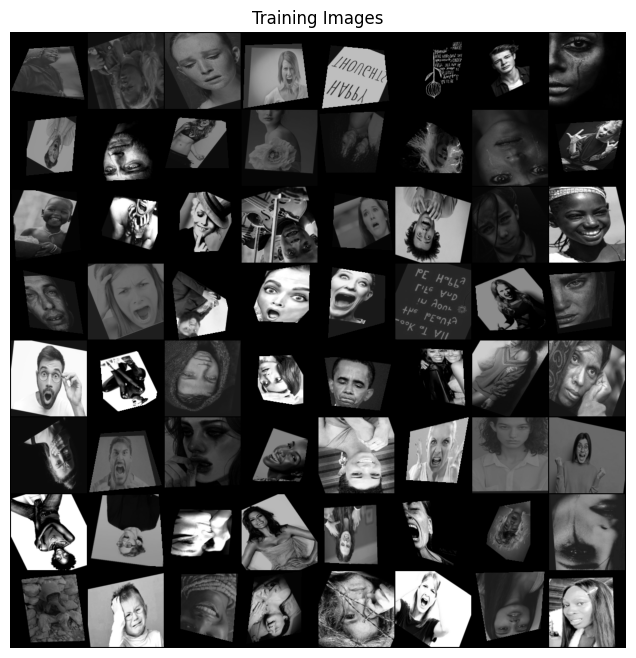

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid
from torchvision import transforms 

# Define train_transform for data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=(-30,30), translate=(0.15,0.15), scale=(0.85,1.15)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomResizedCrop(size=(150, 150), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5), # added transformations after the 3rd model run through, which found the training to be 100% beforehand. Code adapted from: https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html?highlight=data+augmentation
    transforms.ToTensor(),
     transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize((0.5,), (0.5,)) 
])

# Define the directory to your training dataset
train_path = '/notebooks/AI-for-Media-project-23-24/my-classification-split/train'  # Path to the directory containing class directories

train_set = torchvision.datasets.ImageFolder(root=train_path,
                                              transform=train_transform)

# Convert PyTorch tensors to NumPy arrays (had to convert PyTorch tensor to NumPy array, due to incorrect data processing.
# I used code adapted from: https://www.geeksforgeeks.org/how-to-convert-pytorch-tensor-to-numpy-array/ then debugged with GPT after my own attempt.
train_numpy = np.array([x.numpy() for x, _ in train_set])

train_numpy = np.moveaxis(train_numpy, 1, -1)
print("Shape of train_numpy:", train_numpy.shape)

# Define DataLoader for batch loading
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Get a batch of training images
real_batch = next(iter(train_loader))

tensor_batch = real_batch[0]

# Plot some training images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")

# The below code was adapted from https://stackoverflow.com/questions/51329159/how-can-i-generate-and-display-a-grid-of-images-in-pytorch-with-plt-imshow-and-t, which explained the same issue where matplotlib was not displaying my images because of image sizing differences.
plt.imshow(make_grid(tensor_batch, padding=2, normalize=True).permute(1, 2, 0).cpu().numpy())
plt.show()

Shape of val_numpy: (936, 150, 150, 1)


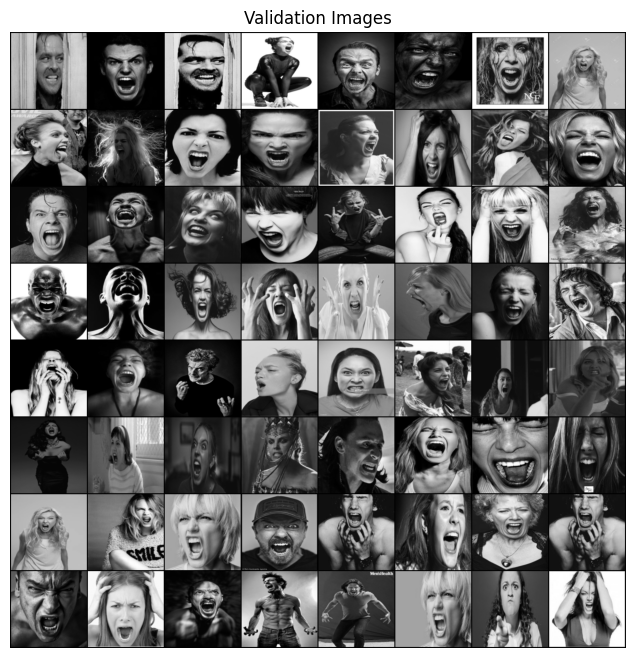

In [13]:
# Validation image transforms using the similar approach as train
import torchvision.datasets as datasets

val_transform = transforms.Compose([
    torchvision.transforms.Resize((150, 150)), 
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define the directory to your validation dataset
val_path = '/notebooks/AI-for-Media-project-23-24/my-classification-split/validation'  # Path to the directory containing class directories

val_set = torchvision.datasets.ImageFolder(root=val_path, transform=val_transform)

# Convert to NumPy array for data processing ( same as the above training data)
# I had an issue with the dimensions of my images
val_numpy = np.array([x.numpy() for x, _ in val_set])

# Code adapted from: https://stackoverflow.com/questions/57438392/rearranging-axes-in-numpy after an error with the shape of val_numpy (374, 1, 150, 150).
    # The error: 'sequential_9". I have an error 'ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 150, 150, 1), found shape=(None, 1, 150, 150)'
val_numpy = np.moveaxis(val_numpy, 1, -1)

# Print shape 
print("Shape of val_numpy:", val_numpy.shape)

# Define DataLoader for batch loading
batch_size = 64
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Get a batch of validation images
real_batch = next(iter(val_loader))

# Convert torch tensor to numpy array and permute the dimensions to match (batch_size, height, width, channels)
tensor_batch = real_batch[0]

# Plot some validation images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Validation Images")

# The code below displays the batch of images using matplotlib
plt.imshow(make_grid(tensor_batch, padding=2, normalize=True).permute(1, 2, 0).cpu().numpy())
plt.show()

### Training model

In [44]:
from keras import regularizers
from keras.models import Sequential # model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization # 
from keras.optimizers import Adam # optimizer
from keras.regularizers import l1, l2 # regularization methods
from keras.callbacks import ModelCheckpoint


# regularization applied to model to prevent overfitting ( of which the training model had 100% accuracy, validation 30%)
# Code adapted from: https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7
no_of_classes = 7

# Define input shape
input_shape = (150, 150,1)

# Build model
model = Sequential()

# Added in L1 regularization to improve overfit. Code adapted from: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-keras.md.
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(picture_size, picture_size, 1)))
output_shape = model.layers[-1].output_shape
print("1st CNN layer shape:", output_shape[1:])


# 1st CNN layer with L2 regularization added as suggested by: https://www.kaggle.com/discussions/questions-and-answers/224485#1231774. 
# model.add(Conv2D(64, (3, 3), padding='same', input_shape=(150, 150, 1)))
#model.add(Conv2D(64, (3, 3), padding='same', input_shape=(picture_size, picture_size, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
print("1st CNN layer shape:", model.output_shape)
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#print("After 1st MaxPooling2D layer shape:", model.output_shape)
model.add(Dropout(0.25))

# 2nd CNN layer + L2 regularization
#model.add(Conv2D(128, (5, 5), padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
print("2nd CNN layer shape:", model.output_shape)
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
print("After 2nd MaxPooling2D layer shape:", model.output_shape)
model.add(Dropout(0.25))


# I added two more convolutional layers,from the origional model, then adjusted the 3rd CNN from 512 down to 256 for to ensure consistent structure.  
l2_reg_strength = 0.0001

# 3rd CNN layer
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(l2_reg_strength)))
print("3rd CNN layer shape:", model.output_shape)
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
print("After 3rd MaxPooling2D layer shape:", model.output_shape)
model.add(Dropout(0.25))

# 4th CNN layer with regularization 
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(2*l2_reg_strength)))
print("4th CNN layer shape:", model.output_shape)
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
print("After 4th MaxPooling2D layer shape:", model.output_shape)
model.add(Dropout(0.25))


#  5th CNN layer
model.add(Conv2D(1024, (3, 3), padding='same'))  
print("5th CNN layer shape:", model.output_shape)
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
print("After 5th MaxPooling2D layer shape:", model.output_shape)
model.add(Dropout(0.25))

#  6th CNN layer
model.add(Conv2D(2048, (3, 3), padding='same'))  
print("6th CNN layer shape:", model.output_shape)
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
print("After 6th MaxPooling2D layer shape:", model.output_shape)
model.add(Dropout(0.25))


model.add(Flatten())
print("After Flatten layer shape:", model.output_shape)

# Add Dense layer with 256 units and relu activation function, and L2 regularization for kernel and bias
#model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))


model.add(Dense(no_of_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))

# Fully connected 1st layer
model.add(Dense(256))
print("Fully connected 1st layer shape:", model.output_shape)
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected 2nd layer
model.add(Dense(512))
print("Fully connected 2nd layer shape:", model.output_shape)
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Output layer
model.add(Dense(no_of_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
print("Output layer shape:", model.output_shape)

# Compile model
opt = Adam(learning_rate=0.0001) # increased after accuracy rate was stuck between 20-30%
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

                                                                                                                                  
model.summary()

epochs = 400 #48

# Define callbacks
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

1st CNN layer shape: (150, 150, 64)
1st CNN layer shape: (None, 148, 148, 32)
2nd CNN layer shape: (None, 72, 72, 64)
After 2nd MaxPooling2D layer shape: (None, 36, 36, 64)
3rd CNN layer shape: (None, 36, 36, 256)
After 3rd MaxPooling2D layer shape: (None, 18, 18, 256)
4th CNN layer shape: (None, 18, 18, 512)
After 4th MaxPooling2D layer shape: (None, 9, 9, 512)
5th CNN layer shape: (None, 9, 9, 1024)
After 5th MaxPooling2D layer shape: (None, 4, 4, 1024)
6th CNN layer shape: (None, 4, 4, 2048)
After 6th MaxPooling2D layer shape: (None, 2, 2, 2048)
After Flatten layer shape: (None, 8192)
Fully connected 1st layer shape: (None, 256)
Fully connected 2nd layer shape: (None, 512)
Output layer shape: (None, 7)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 150, 150, 64)      640       
                                                                 

In [47]:
# Fit model with training and validation data, this trains the model and monitors the validation accuracy, saving the best model wieghts based on validation performance.
# Code debugged with GPT

from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.utils import class_weight
import numpy as np
from torch.utils.data import DataLoader


# I ran into a 'ValueError: Failed to find data adapter that can handle input: <class 'torchvision.datasets.folder.ImageFolder'>, <class 'NoneType'>' which suggested my data for the training and validation were not in an expected format before passing them into the model.fit() function
# The next two lines of code were suggested by GPT, converting PyTorch dataset to MumPy arrays, which then can be used with Keras.
#train_numpy = np.array(train_set)

train_loader = DataLoader(train_set, batch_size=batch_size)
val_loader = DataLoader(val_set, batch_size=batch_size)


#train_numpy = train_set.numpy()
#val_numpy = val_set.numpy()

# Convert data loaders to NumPy arrays. first the train set:
train_numpy = []
train_labels = []

for data, labels in train_loader:
    data = np.transpose(data.numpy(), (0, 2, 3, 1))  # Transpose to (batch_size, height, width, channels)
    train_numpy.append(data) 
    train_labels.append(labels.numpy())
print(" Train set converted!")

train_numpy = np.concatenate(train_numpy, axis=0)
train_labels = np.concatenate(train_labels, axis=0)


# Validation set;
val_numpy = []
val_labels = []

for data, labels in val_loader:
    data = np.transpose(data.numpy(), (0, 2, 3, 1))  # Transpose to (batch_size, height, width, channels)
    val_numpy.append(data)
    val_labels.append(labels.numpy())
print(" Validation set converted!")

val_numpy = np.concatenate(val_numpy, axis=0)
val_labels = np.concatenate(val_labels, axis=0)


# Removing bias within model, as learnt from: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/.
# Class weight calculations. I used the vectors assigned to each emotional class and implemennted a weight for each.
# The model seemed to have an affinity for predicting '2' (happy face) and '4' (sad face), suggesting bias. For these classes, I applied smaller weighting values.
class_weights = {0: 1.0, 1:1.0, 2:0.5, 3:1.0, 4:0.5, 5:1.0,6:1.0}
# Convert class weights to dictionary format
class_weight_dict = dict(enumerate(class_weights)) # code ffrom:https://stackoverflow.com/questions/43481490/keras-class-weights-class-weight-for-one-hot-encoding



# Encode training labels:
label_encoder = LabelEncoder()

#train_labels = train_set.classes
train_labels_encoded = label_encoder.fit_transform(train_labels)

#val_labels_encoded = label_encoder.transform(val_set.classes)
val_labels_encoded = label_encoder.transform(val_labels)
      

    
# Convert labels to categorical formatting
train_labels_encoded = to_categorical(train_labels_encoded,num_classes=7)
print(train_labels_encoded.shape)

val_labels_encoded = to_categorical(val_labels_encoded,num_classes=7)
print(val_labels_encoded.shape)


# Define callbacks
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]



history = model.fit(x=train_numpy, 
                    y=train_labels_encoded,
                    epochs=epochs,
                    validation_data=(val_numpy, val_labels_encoded),
                    class_weight=class_weight_dict,
                    callbacks=callbacks_list)


 Train set converted!
 Validation set converted!
(899, 7)
(936, 7)
Epoch 1/400
29/29 [==============================] - 7s 163ms/step - loss: 7.5036 - accuracy: 0.1290 - val_loss: 3.1384 - val_accuracy: 0.2340
Epoch 2/400
29/29 [==============================] - 4s 143ms/step - loss: 6.6105 - accuracy: 0.2102 - val_loss: 3.1075 - val_accuracy: 0.2340
Epoch 3/400
29/29 [==============================] - 4s 142ms/step - loss: 6.4247 - accuracy: 0.1924 - val_loss: 3.0862 - val_accuracy: 0.2340
Epoch 4/400
29/29 [==============================] - 4s 141ms/step - loss: 6.1689 - accuracy: 0.2024 - val_loss: 3.0772 - val_accuracy: 0.2340
Epoch 5/400
29/29 [==============================] - 4s 141ms/step - loss: 5.9480 - accuracy: 0.1991 - val_loss: 3.0752 - val_accuracy: 0.2340
Epoch 6/400
29/29 [==============================] - 4s 143ms/step - loss: 5.9594 - accuracy: 0.1969 - val_loss: 3.0820 - val_accuracy: 0.2340
Epoch 7/400
29/29 [==============================] - 4s 142ms/step - loss: 

KeyboardInterrupt: 

In [33]:
# Are the train and val shapes as expected?
# code adapted from: https://numpy.org/doc/stable/reference/generated/numpy.ndarray.shape.html
print("Shape of train_numpy:", train_numpy.shape)
print("Shape of train_labels_encoded:", train_labels_encoded.shape)
print("Shape of val_numpy:", val_numpy.shape)
print("Shape of val_labels_encoded:", val_labels_encoded.shape)

Shape of train_numpy: (899, 150, 150, 1)
Shape of train_labels_encoded: (899, 7)
Shape of val_numpy: (936, 150, 150, 1)
Shape of val_labels_encoded: (936, 7)


In [21]:
#train_classes = set(train_set.classes)
#val_classes = set(val_set.classes)

#unseen_labels = val_classes - train_classes
#if unseen_labels:
#    print(f"Unseen labels in validation set: {unseen_labels}")
    
# Now proceed with label encoding
#label_encoder = LabelEncoder()
#train_labels = label_encoder.fit_transform(train_set.classes)
#val_labels = label_encoder.transform(val_set.classes)

In [48]:
# Save the beft fit model
model.save_weights("model.h5")


In [58]:
# Save the entire model
model.save("model.h5")

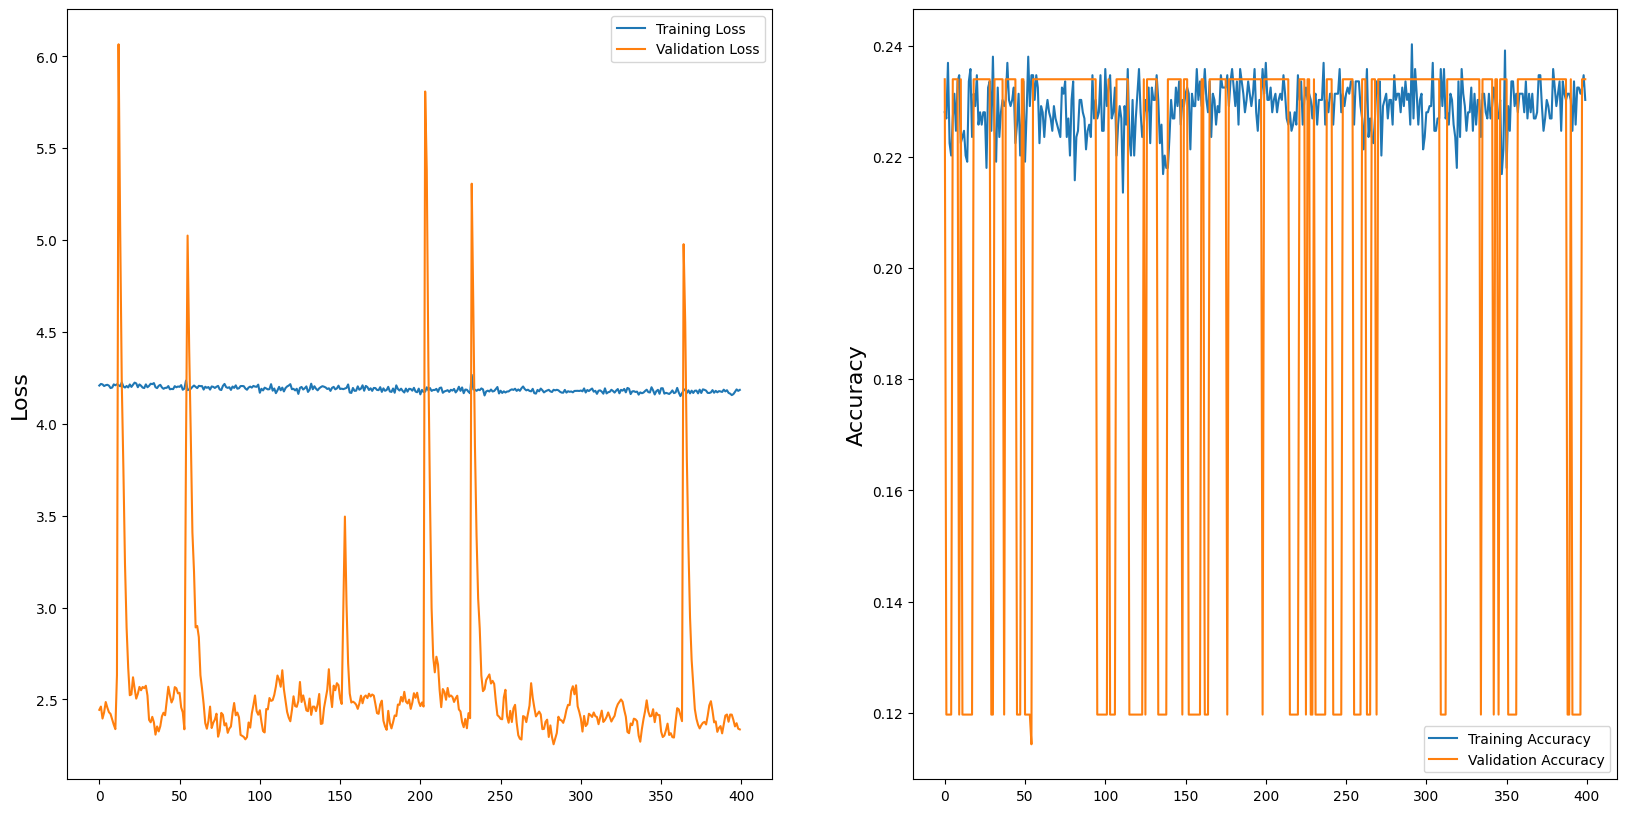

In [49]:
# Plot accuracy and loss 
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [50]:
# Plot pecentage accuracy and loss for training and validation sets
# I asked GPT to fix the following two lines of code which retrievs the results of the val-train results. I did not know that [-1] was neeeded to fetch the last epoch results.
final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]

# Convert result into %
training_accuracy_percentage = final_training_accuracy * 100
validation_accuracy_percentage = final_validation_accuracy * 100

#Code adapted from: https://www.askpython.com/python/examples/print-a-percentage-value-in-python
print("Final Training Accuracy: {:.2f}%".format(training_accuracy_percentage))
print("Final Validation Accuracy: {:.2f}%".format(validation_accuracy_percentage))

Final Training Accuracy: 23.03%
Final Validation Accuracy: 23.40%


30/30 [==============================] - 1s 27ms/step


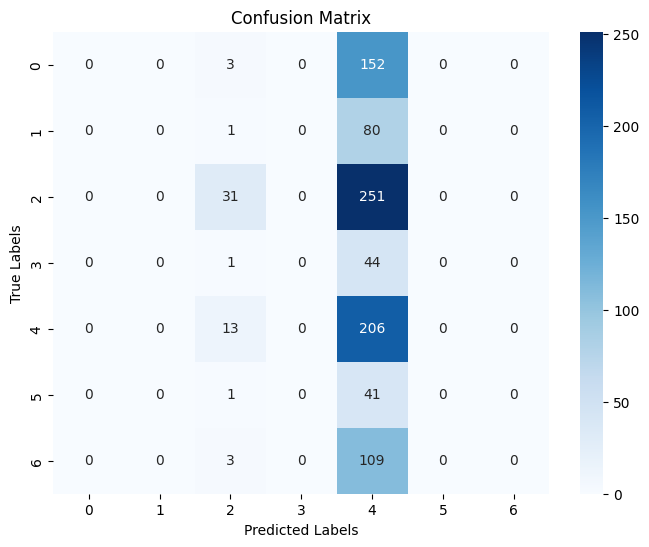

In [51]:
# Plot confusion matrix
# Code adapted from: https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/blob/main/Week-4-Sensing-bodies/02-train-keypoints-classifier.ipynb.
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Make Predictions
predictions = model.predict(val_numpy)
predicted_labels = np.argmax(predictions, axis=1)

# Step 2: Convert Predictions and True Labels
true_labels = np.argmax(val_labels_encoded, axis=1)

# Step 3: Calculate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Step 4: Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### What are my emotional classes?
Finding out which emotional class labels correspond to which emotion in my directory ( stored as one-hot) as made by ImageFolder.

In [26]:
# Code adapted using https://discuss.pytorch.org/t/how-to-get-the-class-names-to-class-label-mapping/470 and GPT for debugging.
import torchvision.datasets as datasets

# Print class info. Code adapted from: https://stackoverflow.com/questions/54734286/how-to-get-class-to-idx-map-for-custom-dataset-in-pytorch
for class_name, class_index in sorted(train_set.class_to_idx.items()):
    print(class_name,class_index)

angry-face 0
disgusted-face 1
happy-face 2
neutral-face 3
sad-face 4
scared-face 5
surprised-face 6


###  Model evaluation
Code adapted from: https://www.tutorialspoint.com/deep_learning_with_keras/deep_learning_with_keras_evaluating_model_performance.htm

In [54]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy
loss, accuracy = model.evaluate(test_set)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

4/4 [==============================] - 10s 2s/step - loss: 3.2127 - accuracy: 0.2473
Test Loss: 3.2126917839050293
Test Accuracy: 0.24732333421707153


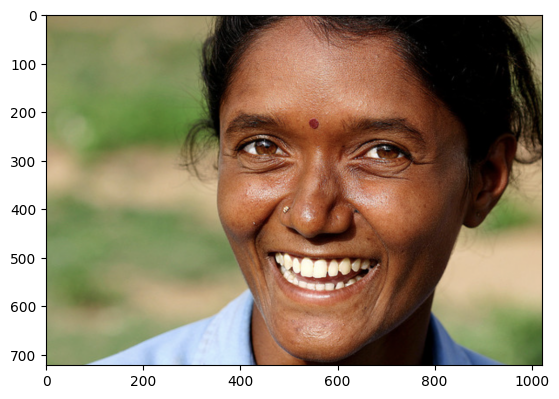

In [61]:
# Dowload a new image for classification and test the model to see the classification progress. 
# Code adapted from: https://github.com/MahdiNavaei/Emotion-Classification-with-CNN/blob/main/projrct.ipynb.
# I chose a happy face because the model seemed to always classify this emotion best and thus should be the quickest way to identify if the model works overall.
img=cv2.imread('new-image.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()


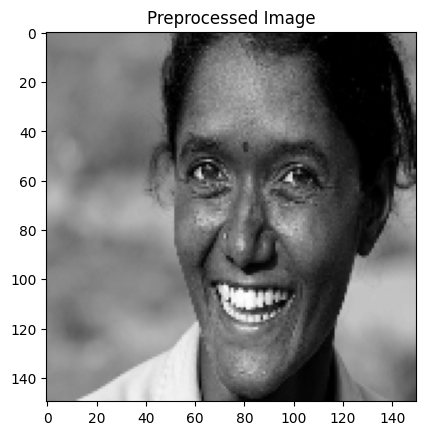

In [62]:
import tensorflow as tf

# resize and add in grayscale to match the train and validation images
resize = tf.image.resize(img, (150, 150))
resize = tf.image.rgb_to_grayscale(resize)
resize = tf.expand_dims(resize, axis=0)  # Add batch dimension
resize = resize / 255.0  # Normalize the image

# Display the preprocessed image
plt.imshow(resize.numpy().squeeze(), cmap='gray')
plt.title("Preprocessed Image")
plt.show()


In [63]:
#Load in model and image details to see which emotional class is predicted.
# Code also adapted from: https://www.tensorflow.org/tutorials/keras/save_and_load

model = tf.keras.models.load_model('model.h5')

predictions = model.predict(resize)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]

# available class labels
class_labels = ['angry-face', 'disgusted-face', 'happy-face', 'neutral-face', 'sad-face', 'scared-face', 'surprised-face']

# Print predicted class label
predicted_class_label = class_labels[predicted_class_index]
print("Predicted Class Label:", predicted_class_label)

1/1 [==============================] - 0s 291ms/step
Predicted Class Label: sad-face
